In [65]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Property Assessment 2018
- Data is pulled from City of Edmonton Open Data portal.
- `nb` stands for neighbourhood
- The `ward` and `neighbourhood ID` columns are dropped from the DataFrame
    - The ward information is not understandable by the average homeowner
    - The neighbourhood name and ID are synonymous and present in all datasets 

### Set the correct data types for each of the remaining columns and reorder columns

In [66]:
col_names = ['acc_num', 'suite', 'number', 'street', 'value', 'class', 
             'nb_id', 'nb', 'ward', 'garage', 'lat', 'long']
col_dtypes = {'acc_num':np.int32, 'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}
col_keep = ['acc_num', 'nb', 'class', 'value', 'suite', 'number', 'street',
             'garage', 'lat', 'long']

df = pd.read_csv('Property_Assessment_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')[col_keep]

# Property Information 2018

In [67]:
col_names = ['acc_num', 'suite', 'number', 'street', 'legal_desc', 'zoning', 
             'lot_size', 'year_built', 'nb_id', 'nb', 'ward', 'lat', 'long']
col_dtypes = {'acc_num':np.int32, 'zoning':object, 'lot_size':object, 'year_built':object}
col_keep = ['acc_num', 'zoning', 'lot_size', 'year_built', 'nb']

df_info = pd.read_csv('Property_Information_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, low_memory=False)[col_keep]

### Remove and verify the number of null neighbourhood ID records
- This dataset contains one record without a neighbourhood ID.
    - This record has a substantially lower property assessment value.
    - This record represents an outlier in the nearly 400,000 records

In [68]:
df_null = df[df.nb.isnull()]
df_info_null = df_info[df_info.nb.isnull()]

df_cleaned = df[~df.nb.isnull()]
df_info_cleaned = df_info[~df_info.nb.isnull()]
print('The number of null neighbourhood records in df = {}'.format(len(df_null)))
print('The number of null neighbourhood records in df_info = {}'.format(len(df_info_null)))

The number of null neighbourhood records in df = 1
The number of null neighbourhood records in df_info = 1


## Merge the data and info DataFrames

### Filter the data for only the residential entries. To eliminate large malls and high-rises.

**It has been found through exploratory data analysis that residential zonings are more reliable than Edmonton's class designators**

![West Edmonton Mall](WEM.png)

In [162]:
df_info_cleaned = df_info_cleaned[['acc_num', 'zoning', 'lot_size', 'year_built']]

df_clean = df_cleaned.merge(df_info_cleaned, on='acc_num')

df_clean['zoning'] = df_clean['zoning'].fillna('')
df_index = df_clean.zoning.str.contains('R')
df_clean = df_clean[df_index]

df_clean = df_clean[df_clean['class'] == 'Residential']

df_clean = df_clean[df_clean['value'] > 20000]

df_clean = df_clean[df_clean['value'] < 10000000]

## Missing street data is also found to be indicative of inconsequential records
- (a) Any lookup system would be reliant on accurate street data for indentification of the property
- (b) Many of these records have significantly low or high valuations (on Google Maps, these locations seem to be research facilites, walkways, signage, community buildings, etc.)

In [163]:
df_street_null = df_clean[df_clean.street.isnull()]

df_clean = df_clean[~df_clean.street.isnull()]

print('The number of null street records in df_clean = {}'.format(len(df_street_null)))

The number of null street records in df_clean = 205


# Edmonton Criminal Incidents by Neibourhood
- Data is pulled from City of Edmonton Open Data portal.
- The two data frames will be joined on `nb` neighbourhood name.

### Rename the columns more logically and to align with `df_cleaned`

In [164]:
col_list = ['nb', 'violation', 'year', 'quarter', 'month', 'num_incidents']
col_dtypes = {'nb':'category', 'violation':'category', 'year':str, 'month':str}
col_order = ['nb', 'violation', 'num_incidents', 'year', 'month', 'quarter']

df_crime = pd.read_csv('EPS_Neighbourhood_Criminal_Incidents.csv', header=0, 
                      names=col_list, dtype=col_dtypes)[col_order]

### Convert `year` and `month` to a datetime column

In [165]:
datetime = pd.to_datetime(df_crime['year'] + '-' + df_crime['month'])

df_crime['record_month'] = datetime

df_crime = df_crime[['nb', 'violation', 'num_incidents', 'record_month']]

df_crime.set_index('record_month', inplace=True)

### Splice the crime data for only 2018 to avoid overexposing crime incidents in older neighbourhoods.

In [166]:
crime2018 = df_crime.loc['2018']
incidents2018 = crime2018.pivot_table(values='num_incidents', index='nb', 
                                      columns='violation', fill_value=0, aggfunc='sum')

### Merge the two dataframes to generate a complete and cleaned dataset
- Reset the index and drop the old index

- Filter on just the most recent crime data (2018)

In [167]:
property_assess = df_clean.merge(incidents2018, left_on='nb', right_index=True)
property_assess.reset_index(inplace=True)
property_assess.drop('index', axis=1, inplace=True)
property_assess.sort_values(by='value', ascending=True)

acc_num                        nb        class    value suite number  \
280022   6830509                  CARLISLE  Residential    20500   NaN  14310   
234839   4301032          WESTVIEW VILLAGE  Residential    20500   167  10770   
283859   4275160                 EVERGREEN  Residential    20500   NaN    613   
42093    4078044            BULYEA HEIGHTS  Residential    20500   NaN    341   
241613   6667133                 CASSELMAN  Residential    20500   NaN  14515   
234423   4307112          WESTVIEW VILLAGE  Residential    20500  1104  10770   
266410   9291261             TWEDDLE PLACE  Residential    21000   NaN   2024   
106071   9243841                 LEE RIDGE  Residential    21000   NaN    474   
111157   9459546                     SAKAW  Residential    21000   NaN   5610   
284085   4272662                 EVERGREEN  Residential    21000   NaN    544   
234332   4304358          WESTVIEW VILLAGE  Residential    21000   315  10770   
218593   9490707                  HILLVIEW  Residential    21000   NaN    440   
240142   5433701                   BELMONT  Residential    21500   NaN  13551   
283872   4268876                 EVERGREEN  Residential    21500   NaN    184   
234619   4300273          WESTVIEW VILLAGE  Residential    21500    21  10770   
235069   4299517          WESTVIEW VILLAGE  Residential    22000  1446  10770   
284023   4271698                 EVERGREEN  Residential    22000   NaN    295   
235110   4299434          WESTVIEW VILLAGE  Residential    22000  1432  10770   
43129   10032314                RUTHERFORD  Residential    22000   NaN   1530   
283916   4269635                 EVERGREEN  Residential    22000   NaN    195   
293150   2000370          QUESNELL HEIGHTS  Residential    22500   NaN     90   
234840   4305736          WESTVIEW VILLAGE  Residential    22500   705  10770   
54930    4285524               MAPLE RIDGE  Residential    22500   NaN     18   
55465    4284568               MAPLE RIDGE  Residential    22500   NaN     50   
234412   4306718          WESTVIEW VILLAGE  Residential    22500  1001  10770   
234621   4306312          WESTVIEW VILLAGE  Residential    22500   848  10770   
283994   4268629                 EVERGREEN  Residential    22500   NaN      4   
126545   1654268                THORNCLIFF  Residential    22500   NaN  17535   
205048   9993729                 WESTMOUNT  Residential    23000   NaN  10308   
284227   4273454                 EVERGREEN  Residential    23000   NaN    359   
...          ...                       ...          ...      ...   ...    ...   
297550   7995996  RIVER VALLEY TERWILLEGAR  Residential  6334000   NaN  15515   
280850   6843700                  CARLISLE  Residential  6456000   NaN  14104   
247236   9432287                 MEYOKUMIN  Residential  6510000   NaN   5804   
22505    6900500                   BATURYN  Residential  6527000   NaN   9903   
224781   1824614                ALDERGROVE  Residential  6562000   NaN   8403   
253715   1067750      ELLERSLIE INDUSTRIAL  Residential  6573500   NaN   3304   
49715    3771250                KLARVATTEN  Residential  6580000   NaN  18069   
296717   1111186    LEWIS FARMS INDUSTRIAL  Residential  6672500   NaN  20403   
17594   10085677                   GLENORA  Residential  6737000   NaN     64   
120589   9511221          KING EDWARD PARK  Residential  6755000   NaN   7212   
127289   1113729                    SECORD  Residential  6779500   NaN  22511   
118787   6871461                   DUNLUCE  Residential  6972000   NaN  12604   
65748    9227836                 RICHFIELD  Residential  7097500   NaN   8003   
153744   3200862                   BELMEAD  Residential  7621000   NaN   9034   
108083   3169141           BRANDER GARDENS  Residential  7687500   NaN   5440   
59500    1070895                WINDERMERE  Residential  7929500   NaN  18510   
219162   1018951                  HILLVIEW  Residential  7944000   NaN      1   
9858     2606903                 CRESTWO

### Assessment of property outliers

- Scatter plots
- order data

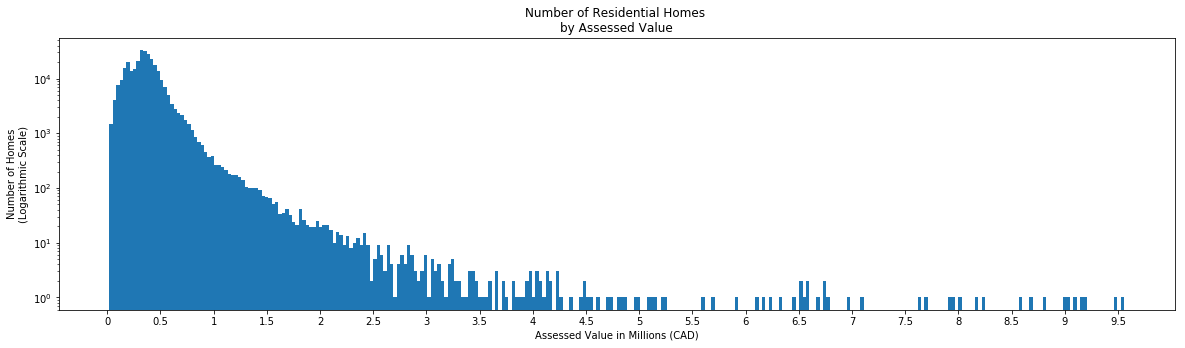

In [175]:
# Generate a plot of residential homes and minimize outliers.
plt.figure(figsize=(20,5))
ax = property_assess['value'].plot(kind='hist', bins=300, logy=True, title='Number of Residential Homes \nby Assessed Value')
ax.set_xlabel('Assessed Value in Millions (CAD)')
ax.set_xticks([i for i in range(0,10000000,500000)])
ax.set_xticklabels([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10])
ax.set_ylabel('Number of Homes\n(Logarithmic Scale)')

plt.show()

### Properties that are assessed significantly higher than the median are zoned by city bylaw as DC1 or DC2 [Referenced Here](https://webdocs.edmonton.ca/InfraPlan/zoningbylaw/bylaw_12800.htm). 

#### As the following investigation of the `.max()` residential valuation shows:

![Griesbach Residential](Residential Outlier.png)

### Properties that are assessed significantly lower than the median are small subdivided lots, primarily used for advertizing billboards.

In [178]:
# Significantly low residential property assessments:
aster = property_assess[property_assess['nb'] == 'ASTER']
industrial = property_assess[property_assess['nb'] == 'ELLERSLIE INDUSTRIAL']

# Maximum 
property_assess[property_assess['value'] == property_assess['value'].max()]

property_assess[property_assess['value'] > 5000000].sort_values(by='value', ascending=False)

acc_num                        nb        class    value suite number  \
288322   1707686         CALLINGWOOD NORTH  Residential  9555000   NaN   7103   
22005    6905426                   BATURYN  Residential  9461000   NaN  10404   
191943   1214881                  MCCAULEY  Residential  9199500   NaN   9238   
221266   1160167                      TAWA  Residential  9172500   NaN   5002   
104848   1128552              BOYLE STREET  Residential  9100500   NaN  10511   
54035    1840008                  LA PERLE  Residential  9045500   NaN   9604   
295940  10002674                  CAVANAGH  Residential  8988000   NaN  10706   
65928    9234709                 RICHFIELD  Residential  8813000   NaN      1   
180399  10517865                  EDGEMONT  Residential  8681000   NaN   5090   
232118   7861255         WESTBROOK ESTATES  Residential  8575500   NaN    108   
280289   6830517                  CARLISLE  Residential  8240500   NaN  14305   
9963     2606952                 CRESTWOOD  Residential  8182000   NaN  13703   
9858     2606903                 CRESTWOOD  Residential  8020500   NaN  13707   
219162   1018951                  HILLVIEW  Residential  7944000   NaN      1   
59500    1070895                WINDERMERE  Residential  7929500   NaN  18510   
108083   3169141           BRANDER GARDENS  Residential  7687500   NaN   5440   
153744   3200862                   BELMEAD  Residential  7621000   NaN   9034   
65748    9227836                 RICHFIELD  Residential  7097500   NaN   8003   
118787   6871461                   DUNLUCE  Residential  6972000   NaN  12604   
127289   1113729                    SECORD  Residential  6779500   NaN  22511   
120589   9511221          KING EDWARD PARK  Residential  6755000   NaN   7212   
17594   10085677                   GLENORA  Residential  6737000   NaN     64   
296717   1111186    LEWIS FARMS INDUSTRIAL  Residential  6672500   NaN  20403   
49715    3771250                KLARVATTEN  Residential  6580000   NaN  18069   
253715   1067750      ELLERSLIE INDUSTRIAL  Residential  6573500   NaN   3304   
224781   1824614                ALDERGROVE  Residential  6562000   NaN   8403   
22505    6900500                   BATURYN  Residential  6527000   NaN   9903   
247236   9432287                 MEYOKUMIN  Residential  6510000   NaN   5804   
280850   6843700                  CARLISLE  Residential  6456000   NaN  14104   
297550   7995996  RIVER VALLEY TERWILLEGAR  Residential  6334000   NaN  15515   
273560   5237524               OVERLANDERS  Residential  6227000   NaN    345   
14557    5689021           MCCONACHIE AREA  Residential  6155000   NaN  17345   
182769   2019008                  PARKVIEW  Residential  6119500   NaN  13804   
181317   1115732                  EDGEMONT  Residential  5918000   NaN  20204   
57029    1071372                WINDERMERE  Residential  5690000   NaN    208   
10339    2612059                 CRESTWOOD  Residential  5587000   NaN     24   
151787   1675800                 SUMMERLEA  Residential  5241500   NaN  17237   
128284   1113737                    SECORD  Residential  5231500   NaN   9831   
108653   4310421           BRANDER GARDENS  Residential  5164000   NaN   5604   
254578  10044027                 BROOKSIDE  Residential  5129000   NaN  14112   
6929     6994503                  SCHONSEE  Residential  5094000   NaN  17331   

                         street  garage        lat        long  \
288322            171 STREET NW   False  53.505306 -113.617118   
22005             172 AVENUE NW   False  53.633709 -113.504317   
191943           110A AVENUE NW   False  53.559620 -113.485029   
221266             31 AVENUE NW   False  53.462669 -113.422152   
104848             92 STREET NW   False  53.550766 -113.476072   
54035             182 STREET NW   False  53.531288 -113.638668   
295940             30 AVENUE SW   False  53.413251 -113.506696   
65928                KEEGANO NW   False  53.469278 -113.463561   
180399    ED

In [179]:
property_assess.columns

Index(['acc_num', 'nb', 'class', 'value', 'suite', 'number', 'street',
       'garage', 'lat', 'long', 'zoning', 'lot_size', 'year_built', 'Assault',
       'Break and Enter', 'Homicide', 'Robbery', 'Sexual Assaults',
       'Theft From Vehicle', 'Theft Of Vehicle', 'Theft Over $5000'],
      dtype='object')

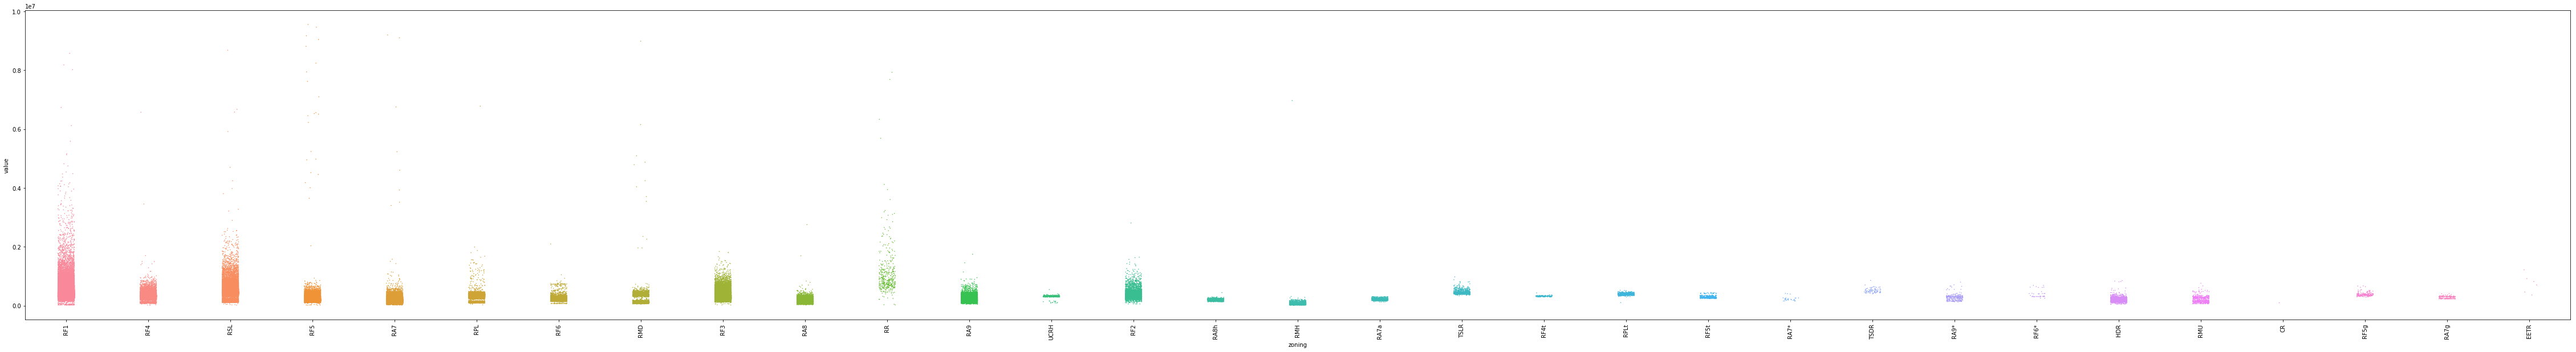

In [180]:
plt.figure(1, figsize=(80,10))

# Overlay a strip plot on the violin plot
sns.stripplot(x='zoning', y='value', data=property_assess, size=1.5, jitter=True)

plt.xticks(rotation=90)

# Display the plot
plt.savefig('zoning values.png')
plt.show()

## Some property assessments are for future developments:

![Aster Neighbourhood Investigation](Aster _NSP_Consolidation.pdf)

Text(0,0.5,'Assessed Value x 10 Billion (CAD)')

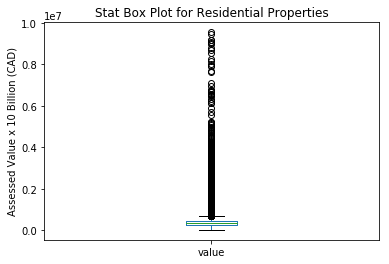

In [181]:
df_res = property_assess[property_assess['class'] == 'Residential']
ax = df_res['value'].plot(kind='box', title='Stat Box Plot for Residential Properties')
ax.set_ylabel('Assessed Value x 10 Billion (CAD)')

## Reshaping of data for analysis

In [182]:
df_grouped = df_cleaned.groupby(['nb']).mean()
df_grouped = df_grouped[['value']]

In [277]:
neighbourhood_assess = df_grouped.merge(incidents2018, left_on='nb', right_index=True)

nb_assess = neighbourhood_assess.reset_index()

nb_assess = nb_assess[nb_assess['value'] < 4400000]

df_index = ~nb_assess.nb.str.contains('INDUSTRIAL')
nb_assess = nb_assess[df_index]

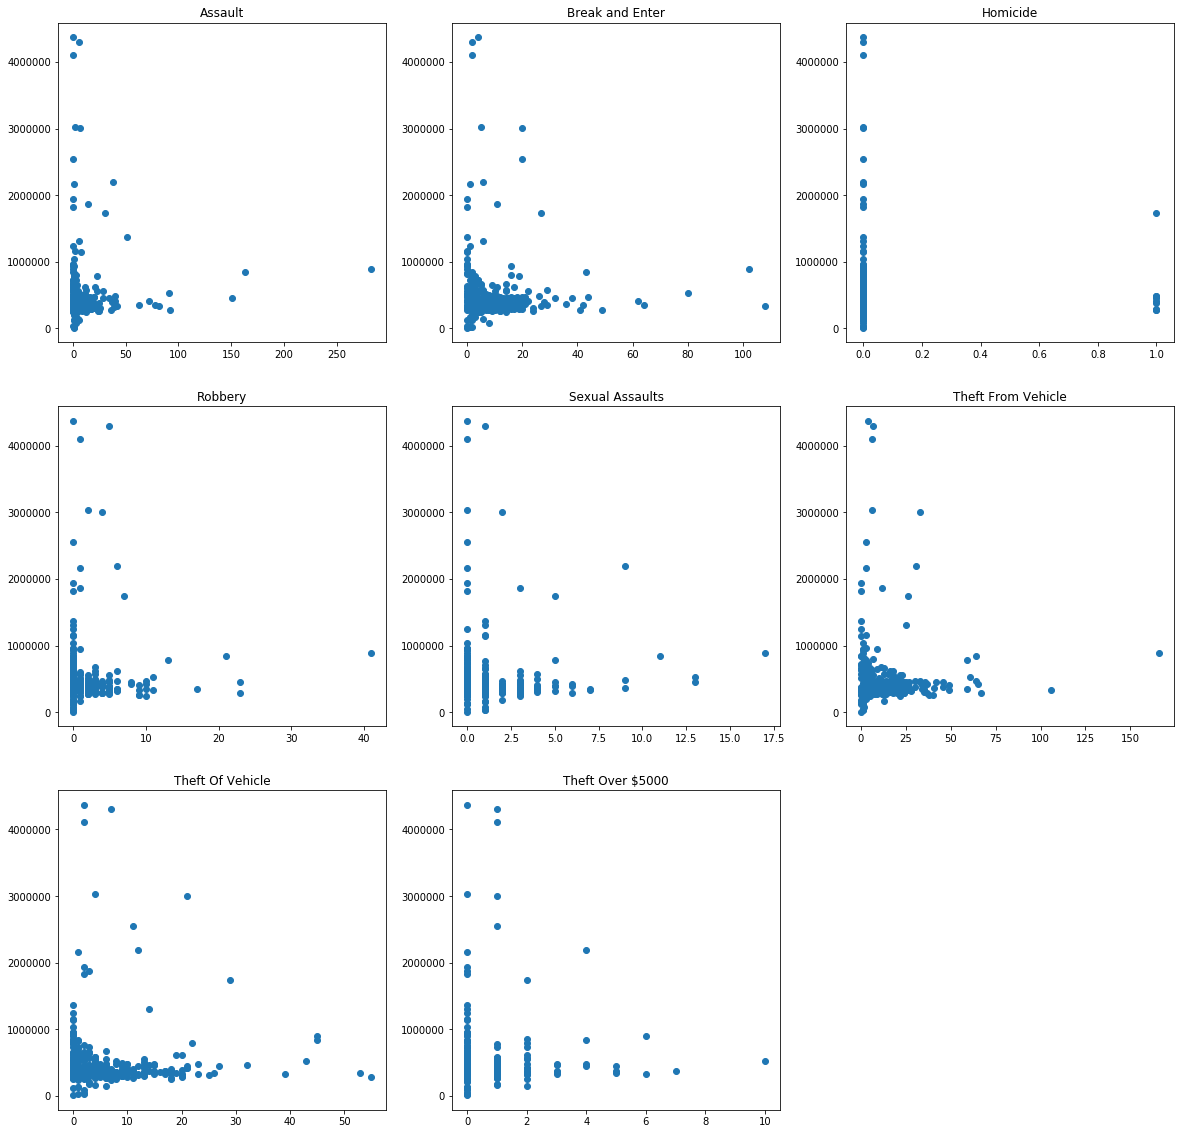

In [278]:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
plt.scatter(x='Assault', y='value', data=nb_assess)
plt.title('Assault')

plt.subplot(3,3,2)
plt.scatter(x='Break and Enter', y='value', data=nb_assess)
plt.title('Break and Enter')

plt.subplot(3,3,3)
plt.scatter(x='Homicide', y='value', data=nb_assess)
plt.title('Homicide')

plt.subplot(3,3,4)
plt.scatter(x='Robbery', y='value', data=nb_assess)
plt.title('Robbery')

plt.subplot(3,3,5)
plt.scatter(x='Sexual Assaults', y='value', data=nb_assess)
plt.title('Sexual Assaults')

plt.subplot(3,3,6)
plt.scatter(x='Theft From Vehicle', y='value', data=nb_assess)
plt.title('Theft From Vehicle')

plt.subplot(3,3,7)
plt.scatter(x='Theft Of Vehicle', y='value', data=nb_assess)
plt.title('Theft Of Vehicle')

plt.subplot(3,3,8)
plt.scatter(x='Theft Over $5000', y='value', data=nb_assess)
plt.title('Theft Over $5000')

plt.show()

## Example Analysis of Incident Type:

In [279]:
def incident_dist(incident):
    '''A function that takes an criminal incident designator,
    (Assault, Break and Enter, Homicide, Robbery, Sexual Assults, Theft From Vehicle,
    Theft Of Vehicle, Theft Over $5000) and returns a histogram distribution.
    '''
    
    print('The maximum number of ' + incident + ' for any neighbourhood in Edmonton 2018 is: \n' 
          + str(nb_assess[incident].max()))
    print('\nThe neighbourhood with the most ' + incident + ' in 2018 is/are: \n' 
          + str(nb_assess[nb_assess[incident] == nb_assess[incident].max()].nb))
    
    ax = nb_assess[incident].plot(kind='hist',range=(0,nb_assess[incident].max()), bins=100, title=incident)
    ax.set_ylabel('Number of Neighbourhoods')
    ax.set_xlabel('Number of Incidents in 2018')
plt.show()

The maximum number of Homicide for any neighbourhood in Edmonton 2018 is: 
1

The neighbourhood with the most Homicide in 2018 is/are: 
2         ALBERTA AVENUE
32             BELVEDERE
56     CALLINGWOOD SOUTH
157             HOLYROOD
163            INGLEWOOD
168             KEHEEWIN
174              KILDARE
283            ROSENTHAL
305        SPRUCE AVENUE
Name: nb, dtype: category
Categories (395, object): [ABBOTTSFIELD, ALBANY, ALBERTA AVENUE, ALBERTA PARK INDUSTRIAL, ..., MILL WOODS PARK, RIVER VALLEY LAURIER, RIVER VALLEY LESSARD NORTH, GLENRIDDING RAVINE]


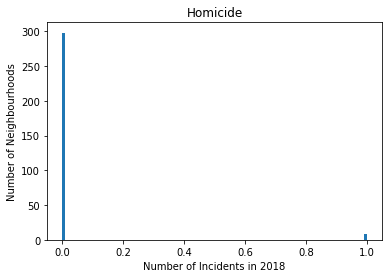

In [280]:
incident_dist('Homicide')

In [281]:
col_names = ['acc_num', 'lot_size', 'year', 'suite', 'number', 'street', 
             'legal_land', 'garage', 'nb', 'value', 'class', 'year_built', 'zoning']
col_dtypes = {'acc_num':np.int32, 'lot_size':np.float32, 'year':np.int32, 
              'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}
col_keep = ['acc_num', 'lot_size', 'year', 'suite', 'number', 'street', 
            'garage', 'nb', 'value', 'class', 'year_built', 'zoning']

chunks = pd.read_csv('Property_Assessment_Data__2012_-_2017.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')

# df_history = pd.concat(chunks, ignore_index=True)

In [282]:
df_history = df_history.sort_values(by='year')

df_history['zoning'] = df_history['zoning'].fillna('')
df_index = df_history.zoning.str.contains('R')
df_history = df_history[df_index]

df_history = df_history[df_history['class'] == 'Residential']

df_history = df_history[df_history['value'] > 20000]

df_history = df_history[df_history['value'] < 10000000]

df_index = ~df_history.nb.str.contains('INDUSTRIAL')
df_history = df_history[df_index]

df_history.head()

acc_num    lot_size  year suite number         street  \
1535812  10085821   95.301003  2012   303  10949  109 STREET NW   
579479    3280203   37.886002  2012   701   9737  112 STREET NW   
1707338   6743694  689.109985  2012   NaN  13819   87 STREET NW   
1707337   8654410  628.898987  2012   NaN   9143   71 AVENUE NW   
579458    7522402  528.499023  2012   NaN  10932   70 AVENUE NW   

                               legal_land  garage                 nb   value  \
1535812           Plan: 0721164  Unit: 11   False  CENTRAL MCDOUGALL  133500   
579479            Plan: 7621302  Unit: 36   False             OLIVER  297000   
1707338   Plan: 6689NY  Block: 3  Lot: 24    True         NORTHMOUNT  317000   
1707337   Plan: 5682HW  Block: 8  Lot: 15    True          HAZELDEAN  330000   
579458   Plan: 2041HW  Block: 27  Lot: 34    True          PARKALLEN  348000   

               class  year_built zoning  
1535812  Residential      1978.0    RA7  
579479   Residential      1967.0    RA9  
1707338  Residential      1971.0    RF1  
1707337  Residential      1954.0    RF3  
579458   Residential      1950.0    RF1

In [301]:
history_pivot = df_history.pivot_table(values='value', index='year', 
                                       columns='nb', aggfunc='median')

In [302]:
history_pivot.head()

nb    ABBOTTSFIELD    ALBANY  ALBERTA AVENUE  ALDERGROVE    ALLARD  ALLENDALE  \
year                                                                            
2012      140500.0  163000.0        204500.0    342500.0  140500.0   346500.0   
2013      147000.0  197000.0        209000.0    347000.0  350000.0   368000.0   
2014      149500.0  180500.0        220500.0    349500.0  414000.0   368000.0   
2015      160000.0  290500.0        232500.0    369000.0  428750.0   403500.0   
2016      167000.0  313000.0        229500.0    373000.0  380500.0   419500.0   

nb    AMBLESIDE  ANTHONY HENDAY TERWILLEGAR    ARGYLL  ASPEN GARDENS  \
year                                                                   
2012   420500.0                         NaN  321000.0       454000.0   
2013   355500.0                         NaN  336000.0       445500.0   
2014   320500.0                    399500.0  342500.0       465000.0   
2015   350500.0                    415000.0  376000.0       497000.0   
2016   394500.0                    415000.0  390000.0       491000.0   

nb      ...     WESTMOUNT  WESTRIDGE  WESTVIEW VILLAGE  WESTWOOD  WILD ROSE  \
year    ...                                                                   
2012    ...      296000.0   538250.0           51000.0  235500.0   375500.0   
2013    ...      311750.0   495000.0           48000.0  240500.0   381500.0   
2014    ...      322000.0   521000.0           50500.0  248500.0   394250.0   
2015    ...      339000.0   563500.0           49000.0  274500.0   418000.0   
2016    ...      341250.0   569000.0           53000.0  263000.0   418500.0   

nb    WINDERMERE  WINDERMERE AREA  WINDSOR PARK  WOODCROFT      YORK  
year                                                                  
2012    375000.0         116500.0      703750.0   307000.0  282000.0  
2013    359500.0              NaN      685750.0   310000.0  281000.0  
2014    381250.0              NaN      712000.0   311500.0  295500.0  
2015    425500.0              NaN      767000.0   348000.0  302500.0  
2016    418000.0              NaN      786250.0   358000.0  311000.0  

[5 rows x 298 columns]

In [303]:
nb = nb_assess.set_index('nb')
nb = nb.iloc[:, 1:]
nb.head()

Assault  Break and Enter  Homicide  Robbery  Sexual Assaults  \
nb                                                                             
ABBOTTSFIELD         14                2         0        3                1   
ALBANY                4                5         0        1                0   
ALBERTA AVENUE       92               41         1       23                6   
ALDERGROVE           12               18         0        2                3   
ALLARD                1                9         0        0                0   

                Theft From Vehicle  Theft Of Vehicle  Theft Over $5000  
nb                                                                      
ABBOTTSFIELD                    10                 6                 0  
ALBANY                           7                 5                 0  
ALBERTA AVENUE                  67                55                 0  
ALDERGROVE                      12                10                 0  
ALLARD                          13                 4                 1

In [325]:
def my_neighbourhood(neighbourhood):
    '''This function takes a string input for the Edmonton neighbourhood in all caps.'''
    
    print('The reported crimes in 2018 for ' + neighbourhood + '\nare given by the following figure:')
    
    my_n = nb.loc[neighbourhood]
    ax = my_n.plot(kind='barh', color='gray', title=neighbourhood + ' Criminal Incidents')
    ax.set_ylabel('Number of Crimes Reported in 2018')
    ax.xaxis.grid(True, which='major', color='w')
    plt.show()
    
    plt.clf
    
    print('The median property value change for ' + neighbourhood + '\nis given by the following figure:')
    
    ax = history_pivot[neighbourhood].plot(color='grey', title=neighbourhood + ' Median Property Value Change')
    ax.set_ylabel('Property Assessed Value')
    plt.show()

The reported crimes in 2018 for STARLING
are given by the following figure:


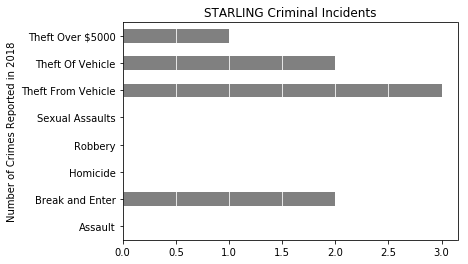

The median property value change for STARLING
is given by the following figure:


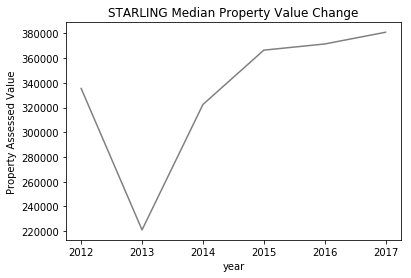

In [328]:
my_neighbourhood('STARLING')